# Lab 10: Keyword Recognition
Gizem Tabak (tabak2)

In [6]:
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import IPython
from scipy.stats import multivariate_normal
from matplotlib import mlab as mlab
from os.path import join
import librosa
import time
import os
from sklearn import mixture
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import audioread

plt.rcParams["figure.figsize"] = (12, 6)

def stft( input_sound, fs, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        t_axis = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        f_axis = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # # Make zero elements equal to the smallest value to avoid log(0) for plotting
        # min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        # stft_output[stft_output == 0] = min_nonzero
# 
        '''
        plt.pcolormesh(t_axis, f_axis, (np.abs(stft_output)**0.4), cmap='gist_gray_r')
        plt.xlabel('Time (sec)')
        plt.ylabel('Freq (Hz)')
        plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
        plt.grid(alpha=0.5)
        plt.colorbar()
        plt.show()
        '''

        return stft_output, t_axis, f_axis
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

In [41]:
# Code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Part 1: Making a digit recognizer

In [42]:
def calculate_distance(template_features, test_features):
    n_temp_frames = np.size(template_features, 1)
    n_test_frames = np.size(test_features, 1)
    D = np.zeros([n_temp_frames, n_test_frames])
    for idx_temp in range(n_temp_frames):
        for idx_test in range(n_test_frames):
            D[idx_temp, idx_test] = 1. - np.dot(template_features[:,idx_temp].T, test_features[:,idx_test])/(np.linalg.norm(template_features[:,idx_temp],2)*np.linalg.norm(test_features[:,idx_test],2))
    return D

def calculate_min_cost(D):
    # 0  - i-1, j-1
    # 1  - i, j-1
    # 2  - i-1, j
    cost = np.zeros(np.shape(D))
    path = np.zeros(np.shape(D))
    for i in range(np.size(D,0)):
        for j in range(np.size(D,1)):
            if i == 0 and j == 0:
                cost[i, j] = D[i, j]
                path[i, j] = -1
            elif j == 0:
                cost[i, j] = cost[i-1, j] + D[i, j]
                path[i, j] = 2
            elif i == 0:
                cost[i, j] = cost[i, j-1] + D[i, j]
                path[i, j] = 1
            else:
                c = [cost[i-1, j-1], cost[i, j-1], cost[i-1, j]]
                cost[i, j] = min(c) + D[i, j]
                path[i, j] = np.argmin(c)
    min_cost = cost[-1, -1]
    i = np.size(D,0) - 1
    j = np.size(D,1) - 1
    optimal_path = []
    while (path[i,j] != -1):
        a = path[i, j]
        optimal_path.append(a)
        if a == 0:
            i -= 1
            j -= 1
        if a == 1:
            j -= 1
        if a == 2:
            i -= 1
    return min_cost, optimal_path[::-1]
        
        
        
            
            
            
            
            

In [57]:
dft_size = 512
zero_pad = dft_size//2
hop_size = dft_size//4
window   = 'hann'
n_mfcc = 128
stft_template_dict = dict.fromkeys(range(10))
# mfcc_template_dict = dict.fromkeys(range(10))

for digit in range(10):
    # Get the templates for each digit
    fs, s = wv.read('data/recordings/%d_jackson_%d.wav'%(digit, 0))
    s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
    stft_template_dict[digit] = np.abs(s_stft)**0.3
    # mfcc_template_dict[digit] = librosa.feature.mfcc(y=s, sr=fs, n_mfcc)

# Get the features from test files
n_test_files = 20
digits_true = np.zeros([n_test_files*10,])
digits_pred = np.zeros([n_test_files*10,])
i = 0
for test_digit in range(10):
    for file_idx in range(1,n_test_files+1):
        fs, s = wv.read('data/recordings/%d_jackson_%d.wav'%(test_digit, file_idx))
        s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
        stft_test = np.abs(s_stft)**0.3
        # mfcc_test = librosa.feature.mfcc(y=s, sr=fs, n_mfcc)
        min_cost_stft = np.zeros(10)
        for template_digit in range(10):
            stft_template = stft_template_dict[template_digit]
            # mfcc_template = mfcc_template_dict[template_digit]
            
            D_stft = calculate_distance(stft_template, stft_test)
            min_cost_stft[template_digit], path_stft = calculate_min_cost(D_stft)
        predict_digit = np.argmin(min_cost_stft)
        digits_true[i] = test_digit
        digits_pred[i] = predict_digit
        i+=1
        # print('Test file is %d-#%d, classified as %d'%(test_digit, file_idx, predict_digit))

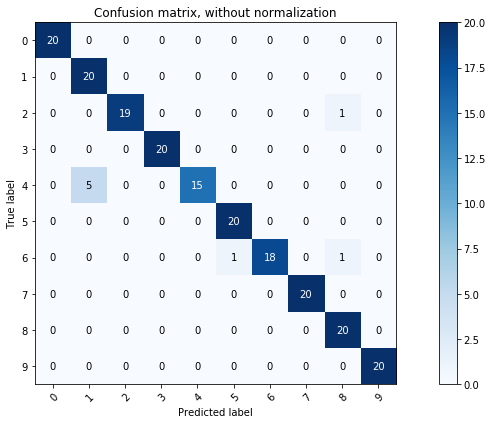

In [63]:
plot_confusion_matrix(digits_true, digits_pred, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

This time, instead of using pre-recorded files, I recorded the digits myself and used a voice activity detector to extract 10 segments for each digit. I applied the same procedure to classify test digits using templates as before.

In [ ]:

def return_clip_idx(digit):
    filename = 'data/recordings_new/%d.wav'%(digit)
    fs, s = wv.read(filename)
    s = s/max(s)
    b, a = sgn.iirfilter(3, 3./(fs/2), btype='lowpass')
    s_filt = sgn.filtfilt(b, a, s**2)

    s_filt_th = s_filt
    th = 0.00005*sum(s_filt**2)
    s_filt_th[s_filt < th] = 0
    plt.plot(s/sum(s**2))
    plt.plot(s_filt_th/sum(s_filt**2), 'r')
    

    s_filt_idx = np.ones(np.shape(s_filt))
    s_filt_idx[s_filt < th] = 0
    idx_all = np.arange(len(s_filt_idx)-1)
    voice_start_idx = min(0, idx_all[np.diff(s_filt_idx) == 1]-round(fs*0.05))
    voice_end_idx = max(idx_all[-1], idx_all[np.diff(s_filt_idx) == -1]+round(fs*0.05))
    print(len(voice_start_idx))
    plt.plot(voice_start_idx, np.ones(np.shape(voice_start_idx)*max(s_filt_th/sum(s_filt**2)), '*')
    plt.plot(voice_end_idx, -np.ones(np.shape(voice_end_idx)*max(s_filt_th/sum(s_filt**2)), '*')
    plt.grid()
    plt.legend(['Signal', 'Energy', ''])
    
    return s, voice_start_idx, voice_end_idx

digit = 3
return_clip_idx(digit)

46


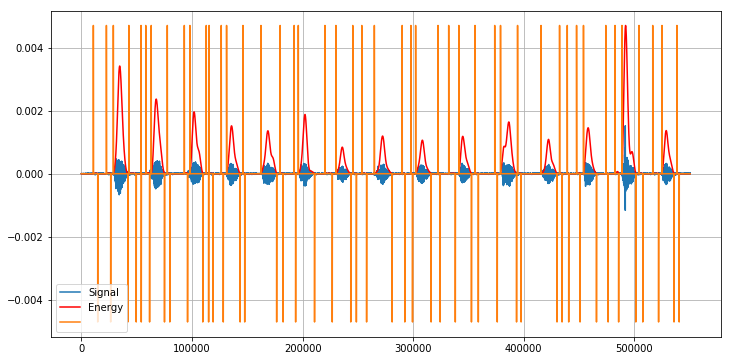

ValueError: not enough values to unpack (expected 4, got 3)

In [63]:
dft_size = 512
zero_pad = dft_size//2
hop_size = dft_size//4
window   = 'hann'
n_mfcc = 128
stft_template_dict = dict.fromkeys(range(10))
# mfcc_template_dict = dict.fromkeys(range(10))
idx_dict = dict.fromkeys(range(10))
s_dict = dict.fromkeys(range(10))
for digit in range(10):
    # Get the templates for each digit
    s_all, fs, voice_start_idx, voice_end_idx = return_clip_idx(digit)
    s = s_all[voice_start_idx[0]:voice_end_idx[0]]
    s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
    stft_template_dict[digit] = np.abs(s_stft)**0.3
    idx_dict[digit] = (voice_start_idx[1:], voice_end_idx[1:])
    s_dict[digit] = s_all
    # mfcc_template_dict[digit] = librosa.feature.mfcc(y=s, sr=fs, n_mfcc)


        

In [43]:
# Get the features from test files
n_test_files = 10
digits_true = np.zeros([n_test_files*10,])
digits_pred = np.zeros([n_test_files*10,])
i = 0
for test_digit in range(10):
    for file_idx in range(1,n_test_files+1):
        s_all = s_dict[digit]
        s_stft, t, f = stft(s_all[idx_dict[digit][0][file_idx]:idx_dict[digit][1][file_idx]], fs, dft_size, hop_size, zero_pad, window)
        stft_test = np.abs(s_stft)**0.3
        # mfcc_test = librosa.feature.mfcc(y=s, sr=fs, n_mfcc)
        min_cost_stft = np.zeros(10)
        for template_digit in range(10):
            stft_template = stft_template_dict[template_digit]
            # mfcc_template = mfcc_template_dict[template_digit]
            D_stft = calculate_distance(stft_template, stft_test)
            min_cost_stft[template_digit], path_stft = calculate_min_cost(D_stft)
        predict_digit = np.argmin(min_cost_stft)
        digits_true[i] = test_digit
        digits_pred[i] = predict_digit
        i+=1
        # print('Test file is %d-#%d, classified as %d'%(test_digit, file_idx, predict_digit))

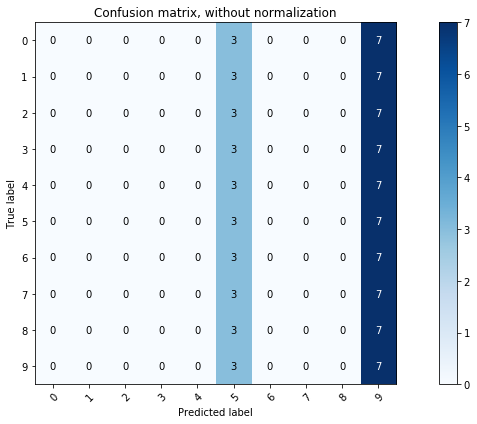

In [44]:
plot_confusion_matrix(digits_true, digits_pred, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()